# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

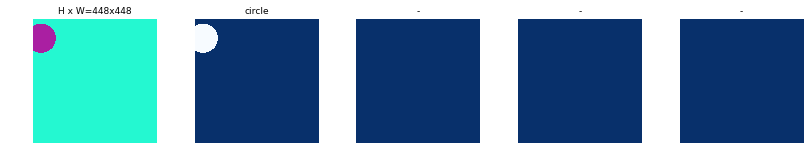

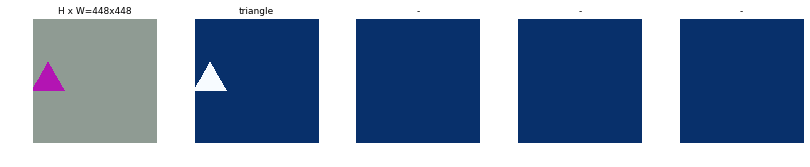

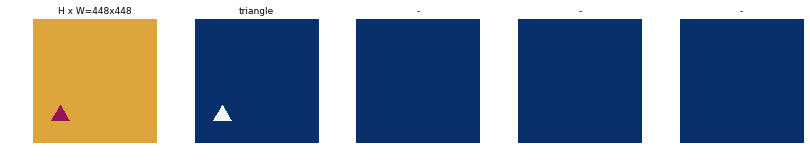

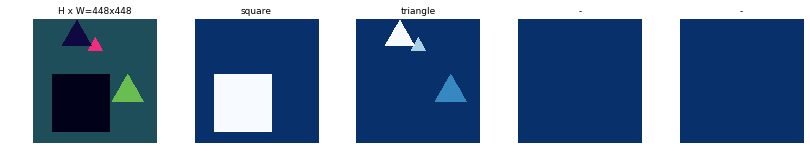

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /traffic/mrcnn/logs/shapes20201014T1800/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
 99/100 [============================>.] - ETA: 1s - loss: 2.0238 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.9217 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.3506

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 140s - loss: 2.0266 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.9319 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.3483 - val_loss: 1.0333 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.7513 - val_mrcnn_class_loss: 0.0318 - val_mrcnn_bbox_loss: 0.1577 - val_mrcnn_mask_loss: 0.0828
Epoch 2/100
100/100 [==============================] - 98s - loss: 0.9236 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5815 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.0999 - val_loss: 0.9935 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.7303 - val_mrcnn_class_loss: 0.0329 - val_mrcnn_bbox_loss: 0.1416 - val_mrcnn_mask_loss: 0.0754
Epoch 3/100
100/100 [==============================] - 99s - loss: 0.7953 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5102 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.0832 - val_loss: 1.0013 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.

100/100 [==============================] - 99s - loss: 0.2284 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.0464 - val_loss: 0.4589 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.2983 - val_mrcnn_class_loss: 0.0236 - val_mrcnn_bbox_loss: 0.0548 - val_mrcnn_mask_loss: 0.0775
Epoch 24/100
100/100 [==============================] - 101s - loss: 0.2431 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0503 - val_loss: 0.3163 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1599 - val_mrcnn_class_loss: 0.0517 - val_mrcnn_bbox_loss: 0.0438 - val_mrcnn_mask_loss: 0.0593
Epoch 25/100
100/100 [==============================] - 100s - loss: 0.2349 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0492 - val_loss: 0.2107 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss:

100/100 [==============================] - 99s - loss: 0.1454 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0391 - val_loss: 0.3021 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.1962 - val_mrcnn_class_loss: 0.0300 - val_mrcnn_bbox_loss: 0.0275 - val_mrcnn_mask_loss: 0.0462
Epoch 46/100
100/100 [==============================] - 98s - loss: 0.1452 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0432 - val_loss: 0.6810 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.4803 - val_mrcnn_class_loss: 0.0978 - val_mrcnn_bbox_loss: 0.0426 - val_mrcnn_mask_loss: 0.0528
Epoch 47/100
100/100 [==============================] - 96s - loss: 0.1628 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0368 - val_loss: 0.3596 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0

100/100 [==============================] - 96s - loss: 0.1413 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0369 - val_loss: 0.3314 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.1783 - val_mrcnn_class_loss: 0.0399 - val_mrcnn_bbox_loss: 0.0416 - val_mrcnn_mask_loss: 0.0695
Epoch 68/100
100/100 [==============================] - 95s - loss: 0.1364 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0362 - val_loss: 0.4322 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.1793 - val_mrcnn_class_loss: 0.1140 - val_mrcnn_bbox_loss: 0.0516 - val_mrcnn_mask_loss: 0.0857
Epoch 69/100
100/100 [==============================] - 96s - loss: 0.1228 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0380 - val_loss: 0.4550 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0

100/100 [==============================] - 99s - loss: 0.0969 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0185 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0323 - val_loss: 0.5816 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.4268 - val_mrcnn_class_loss: 0.0427 - val_mrcnn_bbox_loss: 0.0422 - val_mrcnn_mask_loss: 0.0661
Epoch 90/100
100/100 [==============================] - 97s - loss: 0.0998 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0328 - val_loss: 0.1302 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.0588 - val_mrcnn_class_loss: 0.0270 - val_mrcnn_bbox_loss: 0.0127 - val_mrcnn_mask_loss: 0.0303
Epoch 91/100
100/100 [==============================] - 97s - loss: 0.1105 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0340 - val_loss: 0.4875 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=200, 
            layers="all")


Starting at epoch 100. LR=0.0001

Checkpoint Path: /traffic/mrcnn/logs/shapes20201014T1800/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b 

100/100 [==============================] - 195s - loss: 0.0733 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.0294 - val_loss: 0.1376 - val_rpn_class_loss: 8.5747e-04 - val_rpn_bbox_loss: 0.0879 - val_mrcnn_class_loss: 0.0125 - val_mrcnn_bbox_loss: 0.0108 - val_mrcnn_mask_loss: 0.0255
Epoch 102/200
100/100 [==============================] - 167s - loss: 0.0739 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0106 - mrcnn_mask_loss: 0.0312 - val_loss: 0.3195 - val_rpn_class_loss: 0.0031 - val_rpn_bbox_loss: 0.2641 - val_mrcnn_class_loss: 0.0125 - val_mrcnn_bbox_loss: 0.0122 - val_mrcnn_mask_loss: 0.0275
Epoch 103/200
100/100 [==============================] - 165s - loss: 0.0750 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0101 - mrcnn_mask_loss: 0.0315 - val_loss: 0.3503 - val_rpn_class_loss: 0.0014 - val_rpn_bbo

100/100 [==============================] - 168s - loss: 0.0554 - rpn_class_loss: 9.9937e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0279 - val_loss: 0.3423 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.1756 - val_mrcnn_class_loss: 0.0304 - val_mrcnn_bbox_loss: 0.0502 - val_mrcnn_mask_loss: 0.0850
Epoch 123/200
100/100 [==============================] - 167s - loss: 0.0598 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.0302 - val_loss: 0.3996 - val_rpn_class_loss: 0.0023 - val_rpn_bbox_loss: 0.2817 - val_mrcnn_class_loss: 0.0187 - val_mrcnn_bbox_loss: 0.0378 - val_mrcnn_mask_loss: 0.0590
Epoch 124/200
100/100 [==============================] - 166s - loss: 0.0550 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0070 - mrcnn_mask_loss: 0.0277 - val_loss: 0.4243 - val_rpn_class_loss: 0.0019 - val_rpn_bbo

100/100 [==============================] - 168s - loss: 0.0510 - rpn_class_loss: 9.4646e-04 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0260 - val_loss: 0.5032 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.3990 - val_mrcnn_class_loss: 0.0228 - val_mrcnn_bbox_loss: 0.0270 - val_mrcnn_mask_loss: 0.0509
Epoch 144/200
100/100 [==============================] - 167s - loss: 0.0506 - rpn_class_loss: 8.8192e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0261 - val_loss: 0.2662 - val_rpn_class_loss: 8.3366e-04 - val_rpn_bbox_loss: 0.1109 - val_mrcnn_class_loss: 0.0668 - val_mrcnn_bbox_loss: 0.0249 - val_mrcnn_mask_loss: 0.0629
Epoch 145/200
100/100 [==============================] - 167s - loss: 0.0500 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0271 - val_loss: 0.4141 - val_rpn_class_loss: 0.0029 - val

100/100 [==============================] - 168s - loss: 0.0505 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0041 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0257 - val_loss: 0.1845 - val_rpn_class_loss: 2.4007e-04 - val_rpn_bbox_loss: 0.1369 - val_mrcnn_class_loss: 0.0151 - val_mrcnn_bbox_loss: 0.0076 - val_mrcnn_mask_loss: 0.0247
Epoch 165/200
100/100 [==============================] - 166s - loss: 0.0451 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0242 - val_loss: 0.1884 - val_rpn_class_loss: 2.3718e-04 - val_rpn_bbox_loss: 0.1247 - val_mrcnn_class_loss: 0.0039 - val_mrcnn_bbox_loss: 0.0121 - val_mrcnn_mask_loss: 0.0475
Epoch 166/200
100/100 [==============================] - 168s - loss: 0.0499 - rpn_class_loss: 9.4713e-04 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.0270 - val_loss: 0.2919 - val_rpn_class_loss: 4.3273e-04 -

100/100 [==============================] - 170s - loss: 0.0482 - rpn_class_loss: 9.5123e-04 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0269 - val_loss: 0.3223 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.1751 - val_mrcnn_class_loss: 0.0564 - val_mrcnn_bbox_loss: 0.0215 - val_mrcnn_mask_loss: 0.0676
Epoch 186/200
100/100 [==============================] - 169s - loss: 0.0480 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0268 - val_loss: 0.4212 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.3080 - val_mrcnn_class_loss: 0.0318 - val_mrcnn_bbox_loss: 0.0389 - val_mrcnn_mask_loss: 0.0405
Epoch 187/200
100/100 [==============================] - 169s - loss: 0.0591 - rpn_class_loss: 9.4306e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0084 - mrcnn_mask_loss: 0.0301 - val_loss: 0.2633 - val_rpn_class_loss: 0.0015 - val_rpn

In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /traffic/mrcnn/logs/shapes20201014T1800/mask_rcnn_shapes_0199.h5
Re-starting from epoch 199


original_image           shape: (448, 448, 3)         min:    0.00000  max:  238.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  448.00000  int64
gt_class_id              shape: (3,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:   53.00000  max:  448.00000  int32
gt_mask                  shape: (448, 448, 3)         min:    0.00000  max:    1.00000  bool


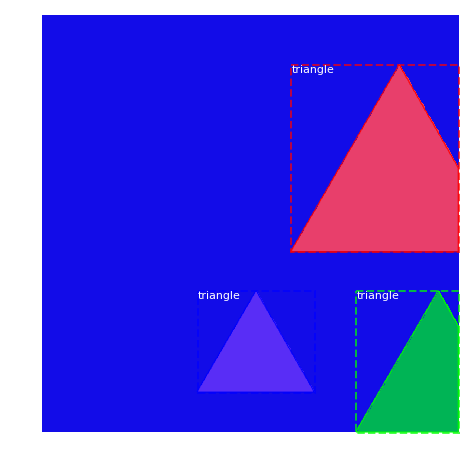

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  134.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  448.00000  int64
anchors                  shape: (1, 50127, 4)         min:   -0.20248  max:    1.05931  float32


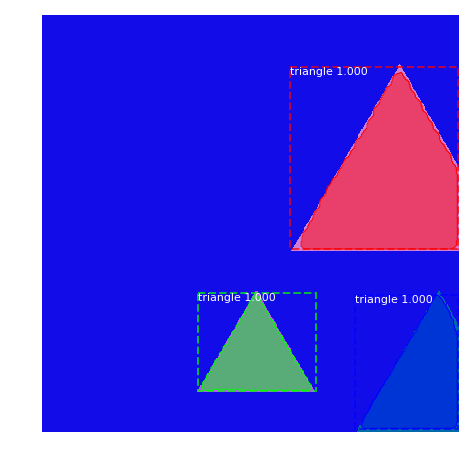

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
